In [6]:
%load_ext autoreload
%autoreload
import tensorflow as tf
import numpy as np
import surreal_single, config
import functools, operator, copy
import tensorflow.contrib.slim as slim
from nets import resnet_v2
from nets.mobilenet import mobilenet_v2
from tensor_info2 import INPUT_TENSOR_INFO, OUTPUT_TENSOR_INFO
tf.reset_default_graph()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
types = tuple(t['type'] for t in INPUT_TENSOR_INFO)
config.BATCH_SIZE = 10
input_tensors = tf.data.Dataset.from_generator(surreal_single.load, types) \
                               .batch(config.BATCH_SIZE) \
                               .prefetch(config.PREFETCH_SIZE) \
                               .make_one_shot_iterator() \
                               .get_next()
tensors = {}
for tensor, info in zip(input_tensors, INPUT_TENSOR_INFO):
    tensor.set_shape(info['shape'])
    tensors[info['name']] = tensor
print(tensors)

{'image': <tf.Tensor 'IteratorGetNext:0' shape=(10, 401, 401, 3) dtype=float32>, 'hm': <tf.Tensor 'IteratorGetNext:1' shape=(10, 401, 401, 16) dtype=float32>, 'so_x': <tf.Tensor 'IteratorGetNext:2' shape=(10, 401, 401, 16) dtype=float32>, 'so_y': <tf.Tensor 'IteratorGetNext:3' shape=(10, 401, 401, 16) dtype=float32>, 'mo_x': <tf.Tensor 'IteratorGetNext:4' shape=(10, 401, 401, 30) dtype=float32>, 'mo_y': <tf.Tensor 'IteratorGetNext:5' shape=(10, 401, 401, 30) dtype=float32>}


In [8]:
config.STRIDE = 16

MD_H = int((config.TAR_H-1)//config.STRIDE)+1
MD_W = int((config.TAR_W-1)//config.STRIDE)+1

DEPTH = [ti['shape'][-1] for ti in OUTPUT_TENSOR_INFO]
RESULT_SHAPE = (config.BATCH_SIZE, MD_H, MD_W, sum(DEPTH))
RESULT_SIZE = functools.reduce(operator.mul, RESULT_SHAPE[1:])
OUTPUT_SHAPE = (config.BATCH_SIZE, config.TAR_H, config.TAR_W, sum(DEPTH))
OUTPUT_SIZE = functools.reduce(operator.mul, OUTPUT_SHAPE[1:])


In [9]:
def bilinear(indices):
    oy = tf.clip_by_value(indices[1], 0, MD_H-1)
    ox = tf.clip_by_value(indices[2], 0, MD_W-1)
    iy = [tf.floor(oy), tf.ceil(oy + 1e-9)]
    ix = [tf.floor(ox), tf.ceil(ox + 1e-9)]
    idx_p = []
    for y in iy:
        for x in ix:
            indices[1] = y
            indices[2] = x
            idx = tf.cast(tf.stack(indices, axis=-1), tf.int32)
            p = (1 - tf.abs(y - oy)) * (1 - tf.abs(x - ox))
            idx_p.append((idx, p))
    return idx_p

def gather_bilinear(params, indices):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        r = tf.gather_nd(params, idx)
        res.append(r * p)
    return tf.add_n(res)

def scatter_bilinear(params, indices, shape):
    idx_p = bilinear(indices)
    res = []
    for idx, p in idx_p:
        r = tf.scatter_nd(idx, params, shape)
        if len(r.shape) > len(p.shape):
            p = tf.expand_dims(p, axis=-1)
        res.append(r * p)
    return tf.add_n(res)

In [10]:
def resize(tensor):
    return tf.image.resize_images(
        tensor,
        (config.TAR_H, config.TAR_W),
        method=tf.image.ResizeMethod.BILINEAR,
        align_corners=True)

with slim.arg_scope(resnet_v2.resnet_arg_scope()):
    _, end_points = resnet_v2.resnet_v2_101(tensors['image'], output_stride=config.STRIDE)
    model_output = end_points['resnet_v2_101/block4']
    print('model_output', model_output)
    hm_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=tf.sigmoid)
    so_x_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=None)
    so_y_pred = slim.conv2d(model_output, config.NUM_KP, [1, 1], activation_fn=None)
    mo_x_pred = slim.conv2d(model_output, config.NUM_EDGE, [1, 1], activation_fn=None)
    mo_y_pred = slim.conv2d(model_output, config.NUM_EDGE, [1, 1], activation_fn=None)

    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    b, y, x, i = np.mgrid[:config.BATCH_SIZE, :MD_H, :MD_W, :config.NUM_EDGE]
    for _ in range(config.NUM_RECURRENT):
        mo_p = [b, y+mo_y_pred, x+mo_x_pred, i]
        mo_x_pred = gather_bilinear(so_x_pred, mo_p) + mo_x_pred
        mo_y_pred = gather_bilinear(so_y_pred, mo_p) + mo_y_pred
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred = [resize(x) for x in [hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred]]
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)
    so_x_pred, so_y_pred, mo_x_pred, mo_y_pred = [x * config.STRIDE for x in [so_x_pred, so_y_pred, mo_x_pred, mo_y_pred]]
    print(hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred)

model_output Tensor("resnet_v2_101/block4/unit_3/bottleneck_v2/add:0", shape=(10, 26, 26, 2048), dtype=float32)
Tensor("Conv/Sigmoid:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_1/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_2/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_3/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 30), dtype=float32) Tensor("Conv_4/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 30), dtype=float32)
Tensor("Conv/Sigmoid:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_1/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("Conv_2/BatchNorm/FusedBatchNorm:0", shape=(10, 26, 26, 16), dtype=float32) Tensor("add_12:0", shape=(10, 26, 26, 30), dtype=float32) Tensor("add_15:0", shape=(10, 26, 26, 30), dtype=float32)
Tensor("resize_images/ResizeBilinear:0", shape=(10, 401, 401, 16), dtype=float32) Tensor("resize_images_1/ResizeBilinear:0", shape=(10, 401, 401, 

In [14]:
hm_loss = - tf.reduce_mean(tensors['hm'] * tf.log(hm_pred + 1e-9) + (1 - tensors['hm']) * tf.log(1 - hm_pred + 1e-9))
so_loss = tf.abs(tensors['so_x'] - so_x_pred) / config.RADIUS + tf.abs(tensors['so_y'] - so_y_pred) / config.RADIUS
mo_loss = tf.abs(tensors['mo_x'] - mo_x_pred) / config.RADIUS + tf.abs(tensors['mo_y'] - mo_y_pred) / config.RADIUS

disc_only = tf.cast(tensors['hm'], tf.float32)
disc_size = tf.reduce_sum(disc_only, axis=[1, 2]) + 1e-9
so_loss = tf.reduce_mean(tf.reduce_sum(so_loss * disc_only, axis=[1, 2]) / disc_size)

disc_only = tf.cast(tf.gather(tensors['hm'], config.EDGES[:, 0], axis=-1), tf.float32)
disc_size = tf.reduce_sum(disc_only, axis=[1, 2]) + 1e-9
mo_loss = tf.reduce_mean(tf.reduce_sum(mo_loss * disc_only, axis=[1, 2]) / disc_size)

In [15]:
total_loss = hm_loss * 4.0 + so_loss * 1.0 + mo_loss * 0.5

In [16]:
tf.summary.scalar('losses/hm_loss', hm_loss)
tf.summary.scalar('losses/so_loss', so_loss)
tf.summary.scalar('losses/mo_loss', mo_loss)
tf.summary.scalar('losses/total_loss', total_loss)

<tf.Tensor 'losses/total_loss:0' shape=() dtype=string>

In [17]:
tf.summary.histogram("pred_dist/resnet", model_output)
tf.summary.histogram("pred_dist/heatmap", hm_pred)
tf.summary.histogram("pred_dist/short_off_x", so_x_pred)
tf.summary.histogram("pred_dist/short_off_y", so_y_pred)
tf.summary.histogram("pred_dist/mid_off_x", mo_x_pred)
tf.summary.histogram("pred_dist/mid_off_y", mo_y_pred)

tf.summary.histogram("true_dist/heatmap", tensors['hm'])
tf.summary.histogram("true_dist/short_off_x", tensors['so_x'])
tf.summary.histogram("true_dist/short_off_y", tensors['so_y'])
tf.summary.histogram("true_dist/mid_off_x", tensors['mo_x'])
tf.summary.histogram("true_dist/mid_off_y", tensors['mo_y'])

optimizer = tf.train.AdamOptimizer()
train_op = slim.learning.create_train_op(total_loss, optimizer)

checkpoint_path = 'resnet/resnet_v2_101.ckpt'
variables = slim.get_model_variables()
restore_map = {}
for v in variables:
    if not v.name.startswith('resnet'):
        continue
    org_name = v.name.split(':')[0]
    restore_map[org_name] = v
    print(org_name, ':', v.name)
init_assign_op, init_feed_dict = slim.assign_from_checkpoint(checkpoint_path, restore_map)

resnet_v2_101/conv1/weights : resnet_v2_101/conv1/weights:0
resnet_v2_101/conv1/biases : resnet_v2_101/conv1/biases:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/gamma : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/gamma:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/beta : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/beta:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_mean : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_mean:0
resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_variance : resnet_v2_101/block1/unit_1/bottleneck_v2/preact/moving_variance:0
resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/weights : resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/weights:0
resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/biases : resnet_v2_101/block1/unit_1/bottleneck_v2/shortcut/biases:0
resnet_v2_101/block1/unit_1/bottleneck_v2/conv1/weights : resnet_v2_101/block1/unit_1/bottleneck_v2/conv1/weights:0
resnet_v2_101/block1/unit_1/bottleneck

In [18]:
import time, os, shutil
#log_dir = 'logs/log_' + str(time.time())[-5:]
log_dir = 'logs/res_log_test'
shutil.rmtree(log_dir)
os.mkdir(log_dir)

In [ ]:
def InitAssignFn(sess):
    sess.run(init_assign_op, init_feed_dict)
tf.contrib.slim.learning.train(train_op,
                               '/home/ubuntu/personlab/'+log_dir,
                               init_fn=InitAssignFn,
                               log_every_n_steps=100,
                               save_summaries_secs=30,
                              )

Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:global_step/sec: 0.350406
INFO:tensorflow:Recording summary at step 7.
INFO:tensorflow:global_step/sec: 0.398733
INFO:tensorflow:Recording summary at step 20.
INFO:tensorflow:global_step/sec: 0.437153
INFO:tensorflow:Recording summary at step 32.
INFO:tensorflow:global_step/sec: 0.434854
INFO:tensorflow:Recording summary at step 45.
INFO:tensorflow:global_step/sec: 0.434658
INFO:tensorflow:Recording summary at step 59.
INFO:tensorflow:global_step/sec: 0.360985
INFO:tensorflow:Recording summary at step 70.
INFO:tensorflow:global_step/sec: 0.398306
INFO:tensorflow:Recording sum

INFO:tensorflow:Recording summary at step 1496.
INFO:tensorflow:global step 1499: loss = 1.7111 (1.886 sec/step)
INFO:tensorflow:Recording summary at step 1508.
INFO:tensorflow:Recording summary at step 1520.
INFO:tensorflow:Recording summary at step 1534.
INFO:tensorflow:Recording summary at step 1544.
INFO:tensorflow:Recording summary at step 1556.
INFO:tensorflow:Recording summary at step 1568.
INFO:tensorflow:Recording summary at step 1580.
INFO:tensorflow:Recording summary at step 1593.
INFO:tensorflow:global step 1599: loss = 1.5196 (1.879 sec/step)
INFO:tensorflow:Recording summary at step 1604.
INFO:tensorflow:Recording summary at step 1617.
INFO:tensorflow:Recording summary at step 1629.
INFO:tensorflow:Recording summary at step 1640.
INFO:tensorflow:Recording summary at step 1653.
INFO:tensorflow:Recording summary at step 1665.
INFO:tensorflow:Recording summary at step 1677.
INFO:tensorflow:Recording summary at step 1689.
INFO:tensorflow:global step 1699: loss = 1.8080 (1.898

INFO:tensorflow:Recording summary at step 3166.
INFO:tensorflow:Recording summary at step 3178.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 3191.
INFO:tensorflow:global step 3199: loss = 1.0738 (1.872 sec/step)
INFO:tensorflow:Recording summary at step 3202.
INFO:tensorflow:Recording summary at step 3214.
INFO:tensorflow:Recording summary at step 3227.
INFO:tensorflow:Recording summary at step 3238.
INFO:tensorflow:Recording summary at step 3251.
INFO:tensorflow:Recording summary at step 3264.
INFO:tensorflow:Recording summary at step 3275.
INFO:tensorflow:Recording summary at step 3288.
INFO:tensorflow:global step 3299: loss = 1.4262 (1.870 sec/step)
INFO:tensorflow:Recording summary at step 3300.
INFO:tensorflow:Recording summary at step 3313.
INFO:tensorflow:Recording summary at step 3326.
INFO:tensorflow:Recording summary at step 3337.
INFO:tensorflow:Recording summary at step 3350.
INFO:ten

INFO:tensorflow:Recording summary at step 4815.
INFO:tensorflow:Recording summary at step 4826.
INFO:tensorflow:Recording summary at step 4838.
INFO:tensorflow:Recording summary at step 4852.
INFO:tensorflow:Recording summary at step 4863.
INFO:tensorflow:Recording summary at step 4876.
INFO:tensorflow:Recording summary at step 4889.
INFO:tensorflow:global step 4899: loss = 1.0215 (1.868 sec/step)
INFO:tensorflow:Recording summary at step 4900.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 4912.
INFO:tensorflow:Recording summary at step 4925.
INFO:tensorflow:Recording summary at step 4936.
INFO:tensorflow:Recording summary at step 4949.
INFO:tensorflow:Recording summary at step 4962.
INFO:tensorflow:Recording summary at step 4972.
INFO:tensorflow:Recording summary at step 4985.
INFO:tensorflow:Recording summary at step 4998.
INFO:tensorflow:global step 4999: loss = 0.9626 (5.676 sec/step)
INFO:ten

INFO:tensorflow:Recording summary at step 6493.
INFO:tensorflow:global step 6499: loss = 0.7753 (1.896 sec/step)
INFO:tensorflow:Recording summary at step 6506.
INFO:tensorflow:Recording summary at step 6517.
INFO:tensorflow:Recording summary at step 6530.
INFO:tensorflow:Recording summary at step 6542.
INFO:tensorflow:Recording summary at step 6554.
INFO:tensorflow:Recording summary at step 6567.
INFO:tensorflow:Recording summary at step 6579.
INFO:tensorflow:Recording summary at step 6591.
INFO:tensorflow:global step 6599: loss = 0.7172 (1.882 sec/step)
INFO:tensorflow:Recording summary at step 6604.
INFO:tensorflow:Recording summary at step 6615.
INFO:tensorflow:Recording summary at step 6628.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 6641.
INFO:tensorflow:Recording summary at step 6652.
INFO:tensorflow:Recording summary at step 6666.
INFO:tensorflow:Recording summary at step 6679.
INFO:ten

INFO:tensorflow:Recording summary at step 8144.
INFO:tensorflow:Recording summary at step 8154.
INFO:tensorflow:Recording summary at step 8167.
INFO:tensorflow:Recording summary at step 8180.
INFO:tensorflow:Recording summary at step 8191.
INFO:tensorflow:global step 8199: loss = 1.1192 (4.388 sec/step)
INFO:tensorflow:Recording summary at step 8204.
INFO:tensorflow:Recording summary at step 8216.
INFO:tensorflow:Recording summary at step 8228.
INFO:tensorflow:Recording summary at step 8241.
INFO:tensorflow:Recording summary at step 8254.
INFO:tensorflow:Recording summary at step 8266.
INFO:tensorflow:Recording summary at step 8279.
INFO:tensorflow:Recording summary at step 8290.
INFO:tensorflow:global step 8299: loss = 0.7571 (1.878 sec/step)
INFO:tensorflow:Recording summary at step 8303.
INFO:tensorflow:Recording summary at step 8316.
INFO:tensorflow:Recording summary at step 8329.
INFO:tensorflow:Recording summary at step 8341.
INFO:tensorflow:Recording summary at step 8354.
INFO:t

INFO:tensorflow:Recording summary at step 9812.
INFO:tensorflow:Recording summary at step 9824.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 9837.
INFO:tensorflow:Recording summary at step 9849.
INFO:tensorflow:Recording summary at step 9860.
INFO:tensorflow:Recording summary at step 9873.
INFO:tensorflow:Recording summary at step 9885.
INFO:tensorflow:Recording summary at step 9896.
INFO:tensorflow:global step 9899: loss = 0.7450 (1.916 sec/step)
INFO:tensorflow:Recording summary at step 9909.
INFO:tensorflow:Recording summary at step 9921.
INFO:tensorflow:Recording summary at step 9934.
INFO:tensorflow:Recording summary at step 9947.
INFO:tensorflow:Recording summary at step 9958.
INFO:tensorflow:Recording summary at step 9971.
INFO:tensorflow:Recording summary at step 9984.
INFO:tensorflow:Recording summary at step 9995.
INFO:tensorflow:global step 9999: loss = 0.6515 (1.877 sec/step)
INFO:ten

INFO:tensorflow:Recording summary at step 11440.
INFO:tensorflow:Recording summary at step 11453.
INFO:tensorflow:Recording summary at step 11465.
INFO:tensorflow:Recording summary at step 11478.
INFO:tensorflow:Recording summary at step 11490.
INFO:tensorflow:global step 11499: loss = 0.6133 (1.888 sec/step)
INFO:tensorflow:Recording summary at step 11503.
INFO:tensorflow:Recording summary at step 11515.
INFO:tensorflow:Recording summary at step 11527.
INFO:tensorflow:Recording summary at step 11539.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 11552.
INFO:tensorflow:Recording summary at step 11565.
INFO:tensorflow:Recording summary at step 11577.
INFO:tensorflow:Recording summary at step 11589.
INFO:tensorflow:global step 11599: loss = 0.5599 (1.876 sec/step)
INFO:tensorflow:Recording summary at step 11602.
INFO:tensorflow:Recording summary at step 11614.
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 13070.
INFO:tensorflow:Recording summary at step 13081.
INFO:tensorflow:Recording summary at step 13094.
INFO:tensorflow:global step 13099: loss = 0.6682 (1.904 sec/step)
INFO:tensorflow:Recording summary at step 13107.
INFO:tensorflow:Recording summary at step 13119.
INFO:tensorflow:Recording summary at step 13132.
INFO:tensorflow:Recording summary at step 13143.
INFO:tensorflow:Recording summary at step 13156.
INFO:tensorflow:Recording summary at step 13169.
INFO:tensorflow:Recording summary at step 13181.
INFO:tensorflow:Recording summary at step 13193.
INFO:tensorflow:global step 13199: loss = 0.4238 (1.865 sec/step)
INFO:tensorflow:Recording summary at step 13206.
INFO:tensorflow:Recording summary at step 13219.
INFO:tensorflow:Recording summary at step 13232.
INFO:tensorflow:Recording summary at step 13244.
INFO:tensorflow:Recording summary at step 13256.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/m

INFO:tensorflow:Recording summary at step 14707.
INFO:tensorflow:Recording summary at step 14720.
INFO:tensorflow:Recording summary at step 14733.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 14745.
INFO:tensorflow:Recording summary at step 14757.
INFO:tensorflow:Recording summary at step 14770.
INFO:tensorflow:Recording summary at step 14783.
INFO:tensorflow:Recording summary at step 14794.
INFO:tensorflow:global step 14799: loss = 0.6530 (1.865 sec/step)
INFO:tensorflow:Recording summary at step 14806.
INFO:tensorflow:Recording summary at step 14819.
INFO:tensorflow:Recording summary at step 14830.
INFO:tensorflow:Recording summary at step 14843.
INFO:tensorflow:Recording summary at step 14856.
INFO:tensorflow:Recording summary at step 14867.
INFO:tensorflow:Recording summary at step 14879.
INFO:tensorflow:Recording summary at step 14892.
INFO:tensorflow:global step 14899: loss = 0.6348 (1.885 

INFO:tensorflow:Recording summary at step 16344.
INFO:tensorflow:Recording summary at step 16356.
INFO:tensorflow:Recording summary at step 16368.
INFO:tensorflow:Recording summary at step 16381.
INFO:tensorflow:Recording summary at step 16393.
INFO:tensorflow:global step 16399: loss = 0.3613 (1.878 sec/step)
INFO:tensorflow:Recording summary at step 16404.
INFO:tensorflow:Recording summary at step 16417.
INFO:tensorflow:Recording summary at step 16430.
INFO:tensorflow:Recording summary at step 16442.
INFO:tensorflow:Recording summary at step 16454.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 16467.
INFO:tensorflow:Recording summary at step 16480.
INFO:tensorflow:Recording summary at step 16493.
INFO:tensorflow:global step 16499: loss = 0.4883 (1.872 sec/step)
INFO:tensorflow:Recording summary at step 16504.
INFO:tensorflow:Recording summary at step 16517.
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 17989.
INFO:tensorflow:global step 17999: loss = 0.4090 (1.880 sec/step)
INFO:tensorflow:Recording summary at step 18002.
INFO:tensorflow:Recording summary at step 18013.
INFO:tensorflow:Recording summary at step 18026.
INFO:tensorflow:Recording summary at step 18038.
INFO:tensorflow:Recording summary at step 18051.
INFO:tensorflow:Recording summary at step 18063.
INFO:tensorflow:Recording summary at step 18075.
INFO:tensorflow:Recording summary at step 18088.
INFO:tensorflow:global step 18099: loss = 1.0092 (1.890 sec/step)
INFO:tensorflow:Recording summary at step 18100.
INFO:tensorflow:Recording summary at step 18111.
INFO:tensorflow:Recording summary at step 18124.
INFO:tensorflow:Recording summary at step 18137.
INFO:tensorflow:Recording summary at step 18148.
INFO:tensorflow:Recording summary at step 18161.
INFO:tensorflow:Recording summary at step 18174.
INFO:tensorflow:Recording summary at step 18186.
INFO:tensorflow:Saving checkpoint t

INFO:tensorflow:Recording summary at step 19630.
INFO:tensorflow:Recording summary at step 19643.
INFO:tensorflow:Recording summary at step 19656.
INFO:tensorflow:Recording summary at step 19667.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 19680.
INFO:tensorflow:Recording summary at step 19693.
INFO:tensorflow:global step 19699: loss = 0.4200 (1.906 sec/step)
INFO:tensorflow:Recording summary at step 19704.
INFO:tensorflow:Recording summary at step 19718.
INFO:tensorflow:Recording summary at step 19730.
INFO:tensorflow:Recording summary at step 19743.
INFO:tensorflow:Recording summary at step 19754.
INFO:tensorflow:Recording summary at step 19767.
INFO:tensorflow:Recording summary at step 19780.
INFO:tensorflow:Recording summary at step 19793.
INFO:tensorflow:global step 19799: loss = 0.3576 (1.871 sec/step)
INFO:tensorflow:Recording summary at step 19804.
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 21275.
INFO:tensorflow:Recording summary at step 21287.
INFO:tensorflow:global step 21299: loss = 0.5904 (2.082 sec/step)
INFO:tensorflow:Recording summary at step 21299.
INFO:tensorflow:Recording summary at step 21312.
INFO:tensorflow:Recording summary at step 21324.
INFO:tensorflow:Recording summary at step 21336.
INFO:tensorflow:Recording summary at step 21349.
INFO:tensorflow:Recording summary at step 21361.
INFO:tensorflow:Recording summary at step 21373.
INFO:tensorflow:Recording summary at step 21386.
INFO:tensorflow:Recording summary at step 21398.
INFO:tensorflow:global step 21399: loss = 0.5194 (1.865 sec/step)
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 21410.
INFO:tensorflow:Recording summary at step 21422.
INFO:tensorflow:Recording summary at step 21434.
INFO:tensorflow:Recording summary at step 21447.
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 22900.
INFO:tensorflow:Recording summary at step 22912.
INFO:tensorflow:Recording summary at step 22925.
INFO:tensorflow:Recording summary at step 22936.
INFO:tensorflow:Recording summary at step 22949.
INFO:tensorflow:Recording summary at step 22962.
INFO:tensorflow:Recording summary at step 22974.
INFO:tensorflow:Recording summary at step 22986.
INFO:tensorflow:global step 22999: loss = 0.5759 (4.790 sec/step)
INFO:tensorflow:Recording summary at step 22999.
INFO:tensorflow:Recording summary at step 23011.
INFO:tensorflow:Recording summary at step 23024.
INFO:tensorflow:Recording summary at step 23036.
INFO:tensorflow:Recording summary at step 23048.
INFO:tensorflow:Recording summary at step 23062.
INFO:tensorflow:Recording summary at step 23072.
INFO:tensorflow:Recording summary at step 23085.
INFO:tensorflow:global step 23099: loss = 0.4872 (8.098 sec/step)
INFO:tensorflow:Recording summary at step 23098.
INFO:tensorflow:Recording summary a

INFO:tensorflow:Recording summary at step 24571.
INFO:tensorflow:Recording summary at step 24584.
INFO:tensorflow:Recording summary at step 24597.
INFO:tensorflow:global step 24599: loss = 0.5127 (1.859 sec/step)
INFO:tensorflow:Recording summary at step 24608.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 24621.
INFO:tensorflow:Recording summary at step 24633.
INFO:tensorflow:Recording summary at step 24645.
INFO:tensorflow:Recording summary at step 24658.
INFO:tensorflow:Recording summary at step 24670.
INFO:tensorflow:Recording summary at step 24682.
INFO:tensorflow:Recording summary at step 24695.
INFO:tensorflow:global step 24699: loss = 0.3921 (1.877 sec/step)
INFO:tensorflow:Recording summary at step 24707.
INFO:tensorflow:Recording summary at step 24720.
INFO:tensorflow:Recording summary at step 24732.
INFO:tensorflow:Recording summary at step 24744.
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 26200.
INFO:tensorflow:Recording summary at step 26213.
INFO:tensorflow:Recording summary at step 26224.
INFO:tensorflow:Recording summary at step 26237.
INFO:tensorflow:Recording summary at step 26250.
INFO:tensorflow:Recording summary at step 26262.
INFO:tensorflow:Recording summary at step 26275.
INFO:tensorflow:Recording summary at step 26287.
INFO:tensorflow:global step 26299: loss = 0.3556 (2.344 sec/step)
INFO:tensorflow:Recording summary at step 26299.
INFO:tensorflow:Recording summary at step 26311.
INFO:tensorflow:Recording summary at step 26325.
INFO:tensorflow:Recording summary at step 26336.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 26349.
INFO:tensorflow:Recording summary at step 26362.
INFO:tensorflow:Recording summary at step 26374.
INFO:tensorflow:Recording summary at step 26386.
INFO:tensorflow:global step 26399: loss = 0.4826 (2.031 

INFO:tensorflow:Recording summary at step 27837.
INFO:tensorflow:Recording summary at step 27848.
INFO:tensorflow:Recording summary at step 27861.
INFO:tensorflow:Recording summary at step 27874.
INFO:tensorflow:Recording summary at step 27886.
INFO:tensorflow:global step 27899: loss = 0.6201 (2.378 sec/step)
INFO:tensorflow:Recording summary at step 27898.
INFO:tensorflow:Recording summary at step 27910.
INFO:tensorflow:Recording summary at step 27922.
INFO:tensorflow:Recording summary at step 27935.
INFO:tensorflow:Recording summary at step 27948.
INFO:tensorflow:Recording summary at step 27960.
INFO:tensorflow:Recording summary at step 27973.
INFO:tensorflow:Recording summary at step 27985.
INFO:tensorflow:Recording summary at step 27997.
INFO:tensorflow:global step 27999: loss = 0.5697 (1.888 sec/step)
INFO:tensorflow:Recording summary at step 28009.
INFO:tensorflow:Recording summary at step 28021.
INFO:tensorflow:Recording summary at step 28034.
INFO:tensorflow:Recording summary a

INFO:tensorflow:global step 29499: loss = 0.4758 (1.900 sec/step)
INFO:tensorflow:Recording summary at step 29501.
INFO:tensorflow:Recording summary at step 29515.
INFO:tensorflow:Recording summary at step 29526.
INFO:tensorflow:Recording summary at step 29539.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 29552.
INFO:tensorflow:Recording summary at step 29563.
INFO:tensorflow:Recording summary at step 29576.
INFO:tensorflow:Recording summary at step 29588.
INFO:tensorflow:global step 29599: loss = 0.4287 (1.863 sec/step)
INFO:tensorflow:Recording summary at step 29600.
INFO:tensorflow:Recording summary at step 29613.
INFO:tensorflow:Recording summary at step 29626.
INFO:tensorflow:Recording summary at step 29637.
INFO:tensorflow:Recording summary at step 29650.
INFO:tensorflow:Recording summary at step 29663.
INFO:tensorflow:Recording summary at step 29674.
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 31120.
INFO:tensorflow:Recording summary at step 31132.
INFO:tensorflow:Recording summary at step 31145.
INFO:tensorflow:Recording summary at step 31157.
INFO:tensorflow:Recording summary at step 31169.
INFO:tensorflow:Recording summary at step 31182.
INFO:tensorflow:Recording summary at step 31194.
INFO:tensorflow:global step 31199: loss = 0.7329 (1.866 sec/step)
INFO:tensorflow:Recording summary at step 31206.
INFO:tensorflow:Recording summary at step 31219.
INFO:tensorflow:Recording summary at step 31231.
INFO:tensorflow:Recording summary at step 31244.
INFO:tensorflow:Recording summary at step 31257.
INFO:tensorflow:Recording summary at step 31268.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 31281.
INFO:tensorflow:Recording summary at step 31293.
INFO:tensorflow:global step 31299: loss = 0.7998 (1.889 sec/step)
INFO:tensorflow:Recording summary at st

INFO:tensorflow:Recording summary at step 32757.
INFO:tensorflow:Recording summary at step 32769.
INFO:tensorflow:Recording summary at step 32782.
INFO:tensorflow:Recording summary at step 32795.
INFO:tensorflow:global step 32799: loss = 0.3740 (1.872 sec/step)
INFO:tensorflow:Recording summary at step 32807.
INFO:tensorflow:Recording summary at step 32819.
INFO:tensorflow:Recording summary at step 32832.
INFO:tensorflow:Recording summary at step 32844.
INFO:tensorflow:Recording summary at step 32857.
INFO:tensorflow:Recording summary at step 32869.
INFO:tensorflow:Recording summary at step 32881.
INFO:tensorflow:Recording summary at step 32894.
INFO:tensorflow:global step 32899: loss = 0.7801 (1.876 sec/step)
INFO:tensorflow:Recording summary at step 32907.
INFO:tensorflow:Recording summary at step 32919.
INFO:tensorflow:Recording summary at step 32932.
INFO:tensorflow:Recording summary at step 32944.
INFO:tensorflow:Recording summary at step 32956.
INFO:tensorflow:Recording summary a

INFO:tensorflow:Recording summary at step 34409.
INFO:tensorflow:Recording summary at step 34420.
INFO:tensorflow:Recording summary at step 34432.
INFO:tensorflow:Recording summary at step 34445.
INFO:tensorflow:Recording summary at step 34457.
INFO:tensorflow:Recording summary at step 34470.
INFO:tensorflow:Saving checkpoint to path /home/ubuntu/personlab/logs/res_log_test/model.ckpt
INFO:tensorflow:Recording summary at step 34482.
INFO:tensorflow:Recording summary at step 34493.
INFO:tensorflow:global step 34499: loss = 0.3646 (1.885 sec/step)
INFO:tensorflow:Recording summary at step 34507.
INFO:tensorflow:Recording summary at step 34519.
INFO:tensorflow:Recording summary at step 34531.
INFO:tensorflow:Recording summary at step 34544.
INFO:tensorflow:Recording summary at step 34557.
INFO:tensorflow:Recording summary at step 34568.
INFO:tensorflow:Recording summary at step 34581.
INFO:tensorflow:Recording summary at step 34592.
INFO:tensorflow:global step 34599: loss = 0.5620 (1.903 

In [ ]:
from tensorflow.python.tools import inspect_checkpoint
inspect_checkpoint.print_tensors_in_checkpoint_file(checkpoint_path, tensor_name='', all_tensors=False, all_tensor_names=True)

In [16]:

saver = tf.train.Saver()
with tf.Session() as sess:
    checkpoint_path = '/home/ubuntu/personlab/model/model.ckpt-43862'
    saver.restore(sess, checkpoint_path)
    m_out, img, hm, so_x, so_y, mo_x, mo_y = sess.run([model_output, tensors['image'], hm_pred, so_x_pred, so_y_pred, mo_x_pred, mo_y_pred])


INFO:tensorflow:Restoring parameters from /home/ubuntu/personlab/model/model.ckpt-43862


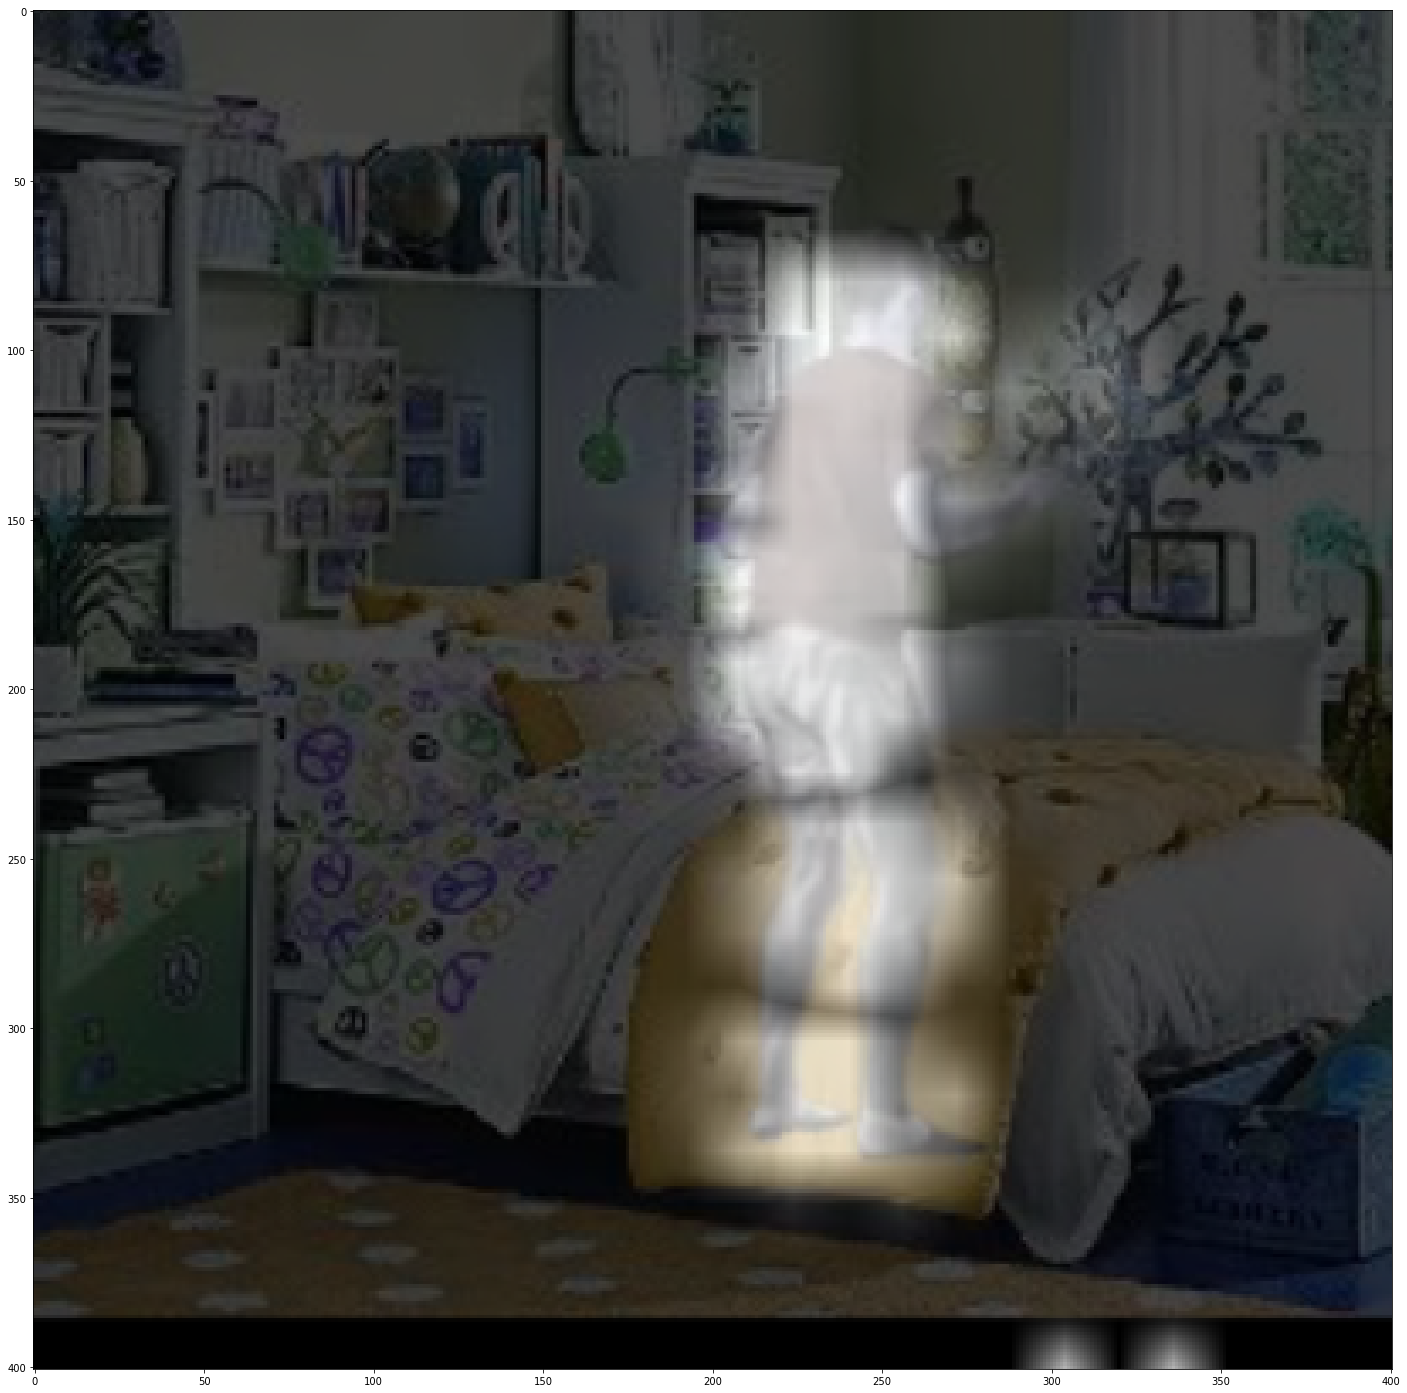

In [63]:
import cv2
from matplotlib import pyplot as plt
from matplotlib import rcParams

def overlay(img, over, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    out *= 1-alpha
    if len(over.shape)==2:
        out += alpha*over[:,:,np.newaxis]
    else:
        out += alpha*over    
    return out
b_i = 9
plt.figure()
plt.imshow(overlay(img[b_i, ...], np.max(hm[b_i, ...], axis=-1), alpha=0.7))

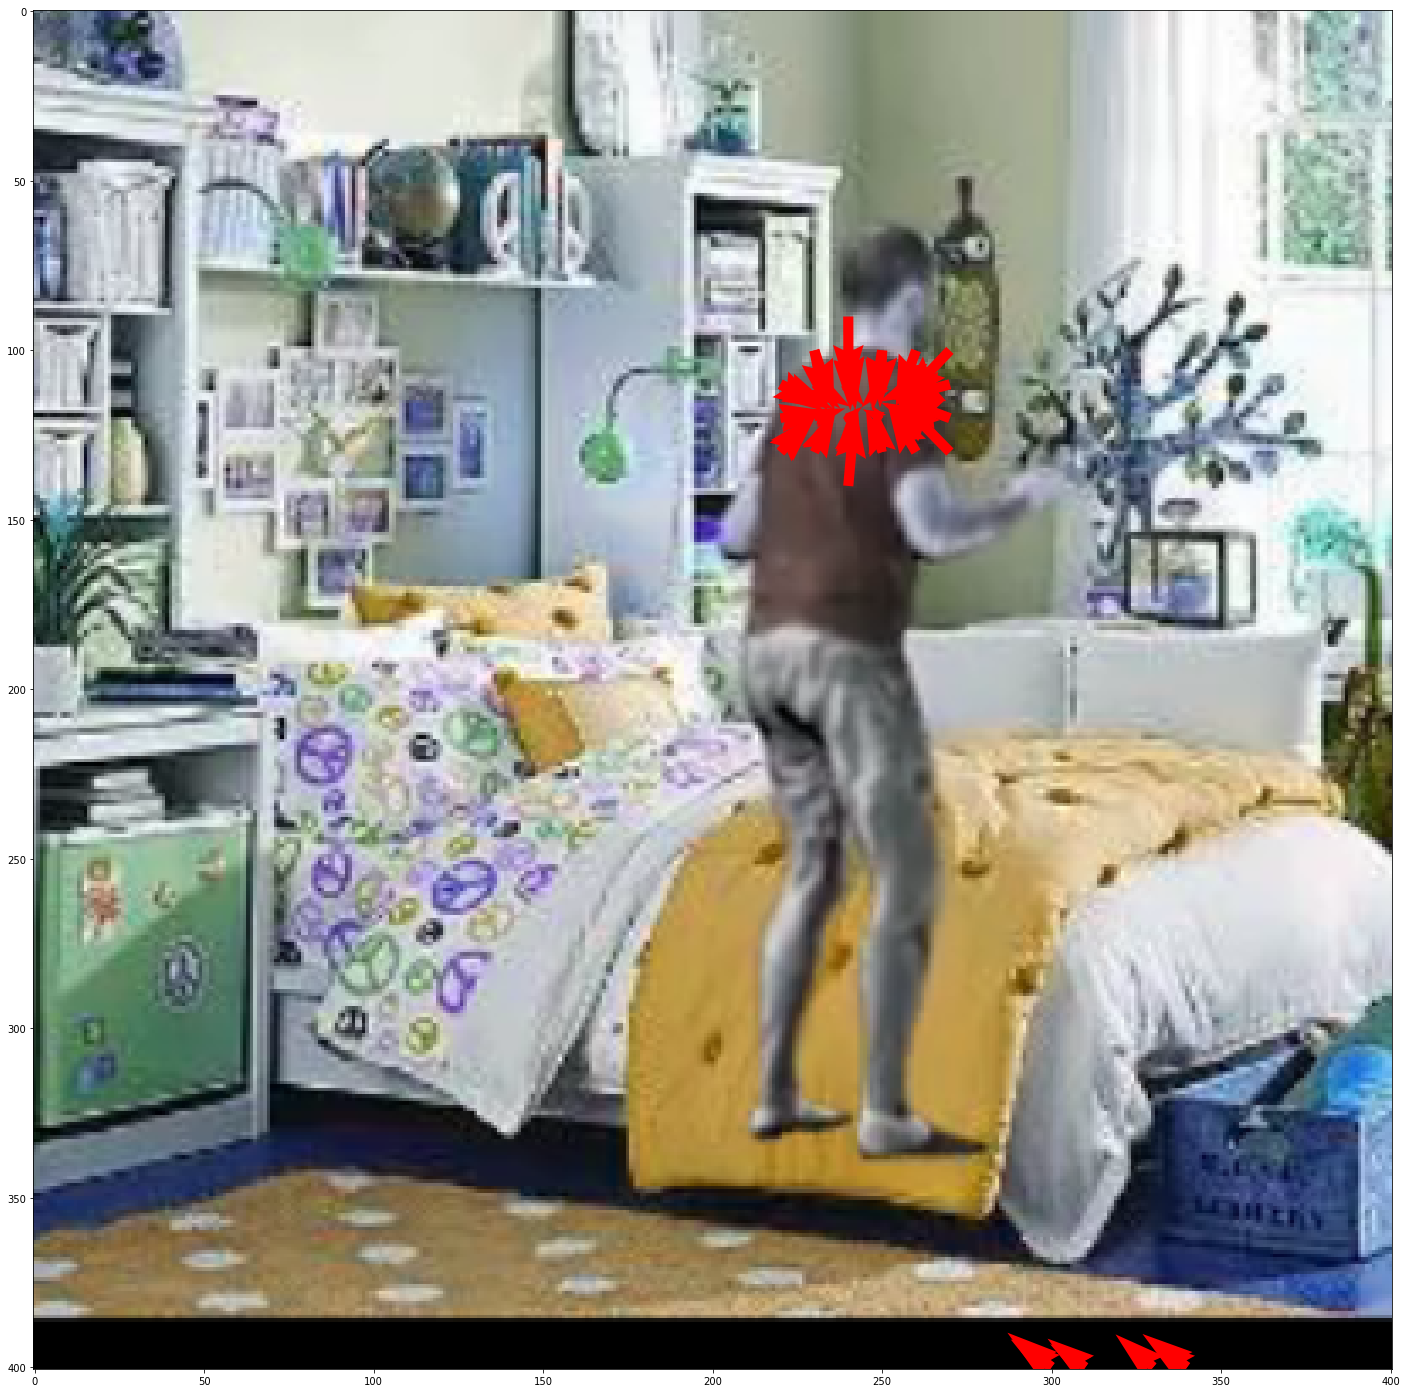

In [64]:
plt.figure()
rcParams['figure.figsize'] = [25, 25]
res = []

def pp(img, alpha=0.5):
    out = img.copy()
    if img.max() > 1.:
        out = out / 255.
    return out

SURREAL_KP_MAP = [
    15, #턱 0
    12, #목 1
    9,  #가슴 2
    16, 18, 20, #왼쪽 어깨, 팔꿈치, 손목 3 4 5
    17, 19, 21, #오른쪽 어깨, 팔꿈치, 손목 6 7 8
    3, #배 9
    1, 4, 7, #왼쪽 엉덩이, 무릎, 발목 10 11 12
    2, 5, 8, #왼쪽 엉덩이, 무릎, 발목 13 14 15
]
for x in range(config.TAR_H):
    if x%10 != 0:
        continue
    for y in range(config.TAR_W):
        if y%10 != 0:
            continue
        i = 12
        for i in [3, 6]:
            if hm[b_i][x][y][i]>0.5 and abs(so_x[b_i][x][y][i]) + abs(so_y[b_i][x][y][i]) > 0:
                res.append((x, y, so_x[b_i][x][y][i], so_y[b_i][x][y][i]))
X, Y, U, V = zip(*res)
plt.quiver(Y, X, U, V, color='r', angles='xy', scale_units='xy', scale=1)
plt.imshow(pp(img[b_i],alpha=0.5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


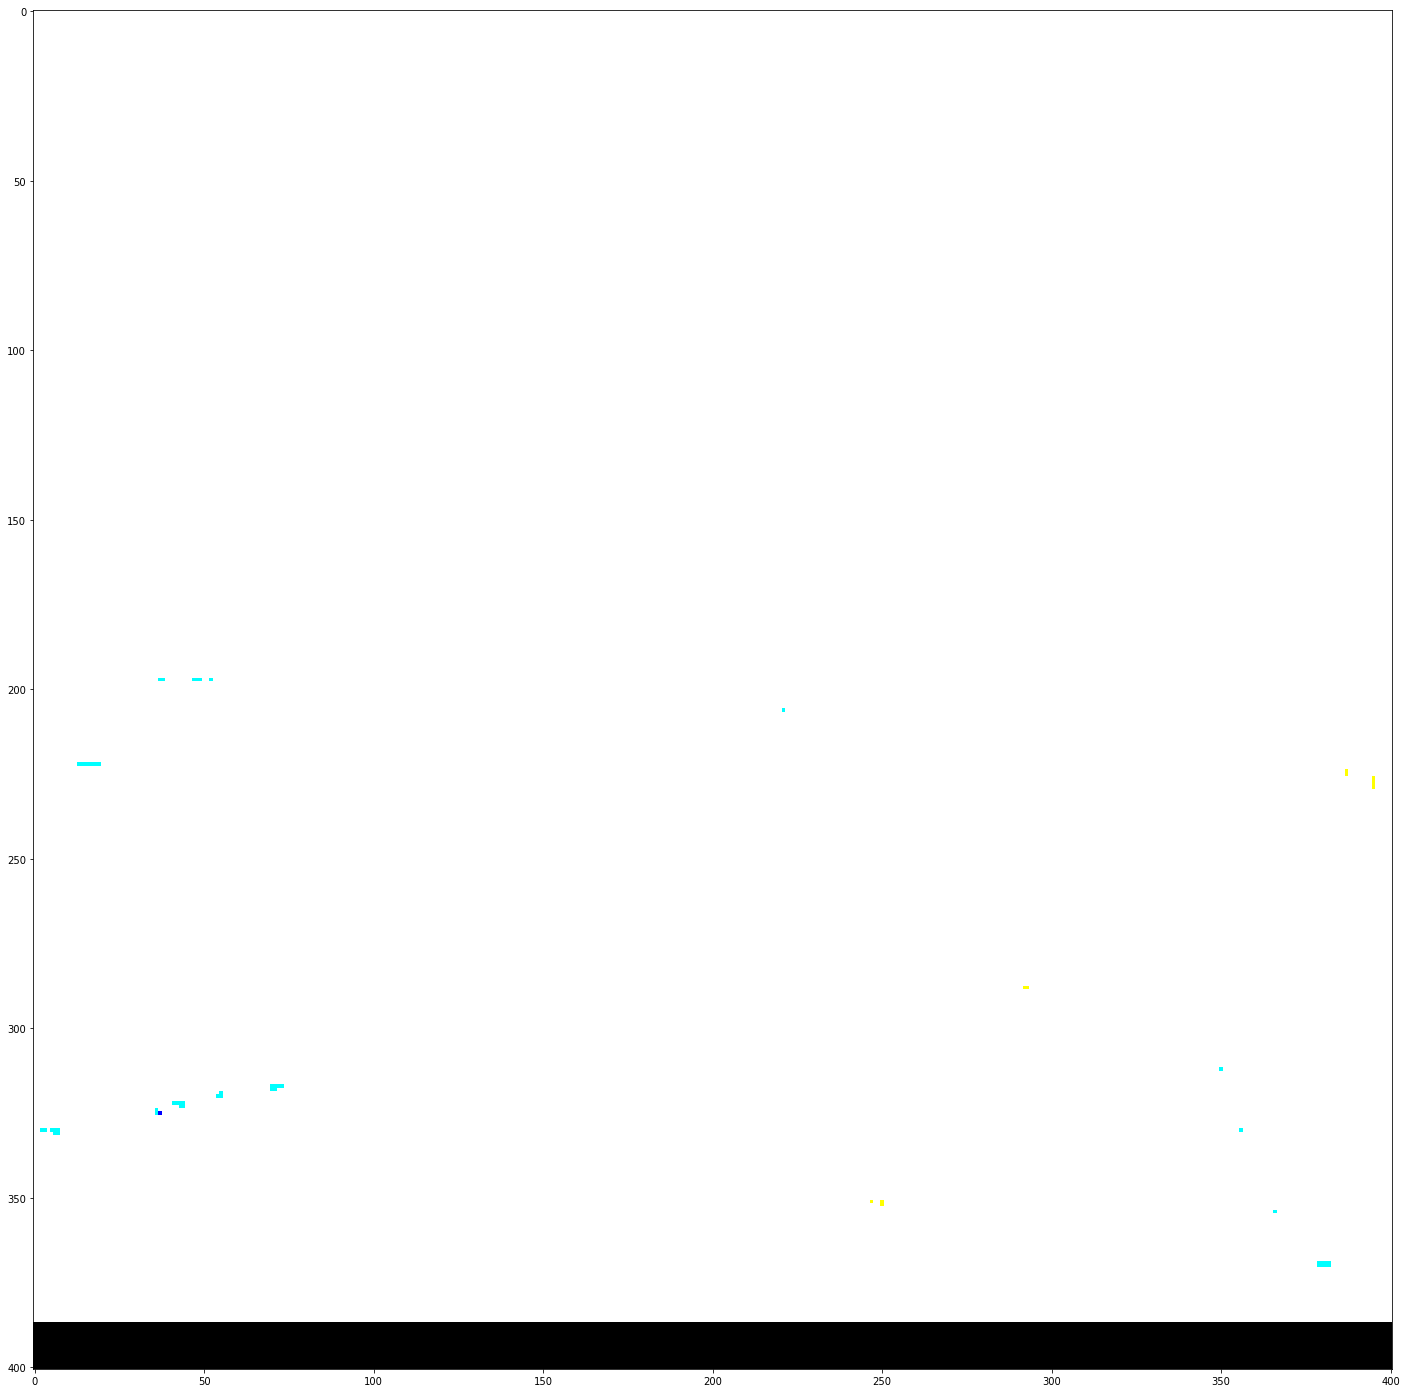

In [65]:

plt.imshow(img[b_i, ...])

In [ ]:
config.EDGES[:, ::-1]